# Importing necessary libraries

In [1]:
from collections import Counter
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt 

from xgboost import XGBClassifier
import numpy as np

# Preparing data

In [4]:
zip_file = ZipFile('../../data/out/clean.zip')
df_clean = pd.read_csv(zip_file.open('clean.csv'))

df_clean.head()

,is_app_approved,bad,annual_income,all0000,all0060,all0061,all0101,all0200,all0201,all0206,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,0.0,15171,10.0,8.000000,8.000000,0.0,9.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,20000,3.0,4.165954,5.237061,0.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,7000,6.0,4.165954,5.237061,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,18000,3.0,1.000000,1.000000,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.0,30000,6.0,4.165954,5.237061,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Oversampling

In [12]:
# oversample = SMOTE()
X = df_clean.drop(columns='bad')
y = df_clean.bad.astype(int)
# counter = Counter(y)
# print(counter)

# X,y = oversample.fit_resample(X,y)
# counter = Counter(y)
# print(counter)

## Standard Scale the data

In [13]:
scaler = StandardScaler()
scaler.fit(X)
scaled_data = pd.DataFrame(scaler.transform(X), columns = X.columns)
X = scaled_data

Splitting the dataset into train/test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Oversampling on training

In [15]:
oversample = SMOTE()
counter = Counter(y_train)
print(counter)

X_train,y_train = oversample.fit_resample(X_train,y_train)
counter = Counter(y_train)
print(counter)

Counter({0: 27212, 1: 2570})
Counter({0: 27212, 1: 27212})


# Models

## Logistic Regression

In [16]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8017 3625]
 [ 485  638]]
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     11642
           1       0.15      0.57      0.24      1123

    accuracy                           0.68     12765
   macro avg       0.55      0.63      0.52     12765
weighted avg       0.87      0.68      0.75     12765



## XGBoost

In [17]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[17:59:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[11549    93]
 [ 1046    77]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     11642
           1       0.45      0.07      0.12      1123

    accuracy                           0.91     12765
   macro avg       0.68      0.53      0.54     12765
weighted avg       0.88      0.91      0.88     12765



## Random Forest

In [18]:
rdnfst = RandomForestClassifier()
rdnfst.fit(X_train, y_train)
y_pred = rdnfst.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11610    32]
 [ 1075    48]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     11642
           1       0.60      0.04      0.08      1123

    accuracy                           0.91     12765
   macro avg       0.76      0.52      0.52     12765
weighted avg       0.89      0.91      0.88     12765



# Week 8 Discussion 

In [19]:
para_grid = {
'n_estimators': [100,200],
 'max_depth': [20,50,100],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 }

rdnfst = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(rdnfst, para_grid, scoring='roc_auc')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [20]:
clf.best_params_

{'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [24]:
display(pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,10.578602,0.253314,0.078766,0.001358,100,1,2,200,"{'max_depth': 100, 'min_samples_leaf': 1, 'min...",0.962275,0.999774,0.999919,0.999924,0.999647,0.992308,0.015017,1
19,10.815869,0.200412,0.080642,0.001373,50,1,2,200,"{'max_depth': 50, 'min_samples_leaf': 1, 'min_...",0.961092,0.999824,0.999899,0.999923,0.999652,0.992078,0.015494,2
21,10.601401,0.238114,0.079920,0.001613,50,1,5,200,"{'max_depth': 50, 'min_samples_leaf': 1, 'min_...",0.960079,0.999747,0.999885,0.999878,0.999634,0.991845,0.015883,3
1,10.175421,0.378451,0.081814,0.003225,20,1,2,200,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.959555,0.999608,0.999767,0.999753,0.999528,0.991642,0.016044,4
39,10.372949,0.097007,0.078431,0.001481,100,1,5,200,"{'max_depth': 100, 'min_samples_leaf': 1, 'min...",0.958994,0.999743,0.999870,0.999860,0.999627,0.991619,0.016313,5


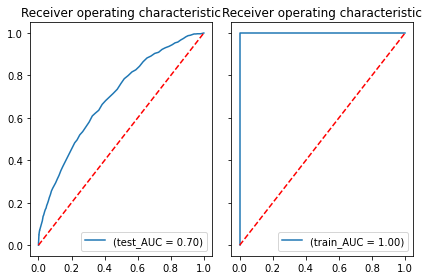

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axes = plt.subplots(1, 2, sharey=True)

logit_roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

axes[0].plot(fpr, tpr, label='(test_AUC = %0.2f)' % logit_roc_auc)
axes[0].plot([0, 1], [0, 1],'r--')

axes[0].title.set_text('Receiver operating characteristic')
axes[0].legend(loc="lower right")


logit_roc_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.figure()
axes[1].plot(fpr, tpr, label='(train_AUC = %0.2f)' % logit_roc_auc)
axes[1].plot([0, 1], [0, 1],'r--')

axes[1].title.set_text('Receiver operating characteristic')
axes[1].legend(loc="lower right")

fig.tight_layout()

plt.show()

In [ ]:
# def final_model(raw_data):
#     clean_data = data_cleaner(raw_data) # Fully cleans data
#     final_proba = BEST_MODEL.predict_proba(clean_data)
#     final_preds = BEST_MODEL.predict(clean_data)